In [84]:
import pandas as pd
from statsmodels.tsa.api import VAR
import pandas_datareader.data as pdr
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

In [11]:
# Load the data
start_date = '2000-01-01'
end_date = dt.datetime.today()
df = pdr.DataReader(name=['SP500', 'GDP', 'UNRATE'], data_source='fred', start=start_date, end=end_date)

# Rename the variables
df.columns = ['S&P500', 'GDP', 'Unemployment_Rate']

# Convert the data to log differences
#df = df.diff().dropna()

In [13]:
df['S&P500_month'] = df['S&P500'].resample('M').mean()

$$
\mathbf{y}_{{t}}=\left[y_{1, t}\ \ y_{2,t}, \ \ \ldots\ \  y_{n, t}\right]^{T}
$$

$$
\mathbf{y}_t=\mathbf{G}_0+\mathbf{G}_1 \mathbf{y}_{t-1}+\mathbf{G}_2 \mathbf{y}_{t-2}+\ldots+\mathbf{G}_{{p}} \mathbf{y}_{t-{p}}+\mathrm{e}_{{t}}
$$

\begin{aligned}
& \mathrm{E}\left(\mathrm{e}_t\right)=0 .  \\
& \mathrm{E}\left(\mathrm{e}_t \mathrm{e}_t^{T}\right)=\Omega  \\
& \mathrm{E}\left(\mathrm{e}_t \mathrm{e}_{t-k}^{T}\right)=0 
\end{aligned}


where $\mathbf{G}_0$ is $n\times 1$ vector, and $\mathbf{G}_i$, $i\in (1,...,p)$ is $n\times n$ matrix, the last term $\mathrm{e}_{{t}}$ is white noise vector. 

A $p$-th order VAR is covariance stationary if 
$$
E\left[\mathbf{y}_t\right]=E\left[\mathbf{y}_{t+{j}}\right]
$$
$$
E\left[\left(\mathbf{y}_{{t}}-\boldsymbol{\mu}\right)\left(\mathbf{y}_{{t}+{j}}-\boldsymbol{\mu}\right)^{T}\right]=E\left[\left(\mathbf{y}_{{s}}-\boldsymbol{\mu}\right)\left(\mathbf{y}_{{s}+{j}}-\boldsymbol{\mu}\right)^{T}\right]=\boldsymbol{\Gamma}_{{j}}
$$
where $t\neq s$

In a more technical view, rearrange the VAR model
$$
\left(\boldsymbol{I}_n-\boldsymbol{G}_1 L-\boldsymbol{G}_2 L^2-\ldots-\boldsymbol{G}_p L^p\right) \boldsymbol{y}_t=\boldsymbol{G}_0+\boldsymbol{e}_t
$$
Replace the lag polynomial by $\boldsymbol{G}(L)$
$$
\boldsymbol{G}(L) y_t=\boldsymbol{G}_0+\boldsymbol{e}_t
$$
For VAR to be stationary, $\boldsymbol{G}(L)$ must be invertible, which requires all roots of characteristic equation outside of unit circle.

A stationary $\text{VAR}$ is equivalent to $\text{VMA}(\infty) $
$$
 y_t=\boldsymbol{G}(L)^{-1}\boldsymbol{G}_0+e_t = \boldsymbol{\mu} +e_t
$$
Rest of steps are similar as $\text{ARIMA}$
$$
\begin{gathered}
\mathbf{y}_{\mathrm{t}}=\boldsymbol{\mu}+\left(\mathrm{I}_{n}+\boldsymbol{\Psi}_1 {L}+\boldsymbol{\Psi}_2 {L}^2+\ldots\right) \boldsymbol{e}_{t} \\
\mathbf{y}_{\mathrm{t}}=\boldsymbol{\mu}+{e}_{{t}}+\boldsymbol{\Psi}_1 \boldsymbol{e}_{\mathrm{t}-1}+\boldsymbol{\Psi}_2 \boldsymbol{e}_{t-2}+\ldots \\
\mathbf{y}_{\mathrm{t}}=\boldsymbol{\mu}+\sum_{{t}=0} \boldsymbol{\Psi}_{{t}} \boldsymbol{e}_{{t}-1}
\end{gathered}
$$

VAR models have two purposes: **forecasting** and **structural analysis**, the former is done by reduced-form VAR, the latter is usually done by SVAR.

And because there is no identification issue, we can directly estimate each equation by OLS.

An example of VAR(1) without constant term

$$
\left(\begin{array}{l}
Y_t \\
X_t
\end{array}\right)=\left(\begin{array}{ll}
a_{11} & a_{12} \\
a_{21} & a_{22}
\end{array}\right)\left(\begin{array}{l}
Y_{t-1} \\
X_{t-1}
\end{array}\right)+\left(\begin{array}{l}
\epsilon_{Y, t} \\
\epsilon_{X, t}
\end{array}\right)
$$

To illustrate estimation process, we import quarterly GDP and monthly consumer sentiment from FRED, however in order to take advantage of abundant monthly observation of consumer sentiment, quarterly GDP shall be resampled into monthly by linear interpolation.

In [99]:
start = dt.datetime(1980, 1, 1)
end = dt.datetime.today()
df = pdr.DataReader(['GDP', 'UMCSENT', 'BSCICP03USM665S'], 'fred', start=start, end=end)
df = df.dropna()
df.columns =['GDP', 'Consumer_confidence', 'Manu_confidence']

In [98]:
df['GDP'] = df['GDP'].resample('MS').interpolate(method='linear')
df.head()

,GDP,Consumer_confidence,Manu_confidence
DATE,,,
1980-01-01,2789.842,67.0,98.589154
1980-04-01,2797.352,52.7,96.316916
1980-07-01,2856.483,62.3,96.240713
1980-10-01,2985.557,75.0,100.229228
1981-01-01,3124.206,71.4,99.482812


In [87]:
def adf_test(x):
    indices = ["Test Statistic", "p-value",
               "# of Lags Used", "# of Observations Used"]
    
    adf_results_all = adfuller(x, autolag="BIC") # you can try 'AIC' too, I personaly prefer 'BIC'
    results = pd.Series(adf_results_all[0:4], index=indices)
    
    for key, value in adf_results_all[4].items():
        results['Critical Value ({})'.format(key)] = value
    results = pd.DataFrame(results, columns = ['statistics'])
    return pd.DataFrame(results)

In [88]:
p_value = {}
for i in df.columns:
    p_value[i] = adf_test(df[i]).iloc[1][0]

In [89]:
p_value

{'GDP': 1.0,
 'Consumer_confidence': 0.03532389821221597,
 'Manu_confidence': 9.232429596018372e-09}

In [90]:
df['GDP_growth'] = df['GDP'].pct_change()
df = df.drop(['GDP'], axis =1)

In [91]:
df = df.dropna()

In [92]:
from statsmodels.tsa.api import VAR
var_model = VAR(df)

In [93]:
var_results = var_model.fit(verbose=True, ic='bic', method='ols')

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 2, FPE -> 2, HQIC ->  2>
Using 2 based on bic criterion


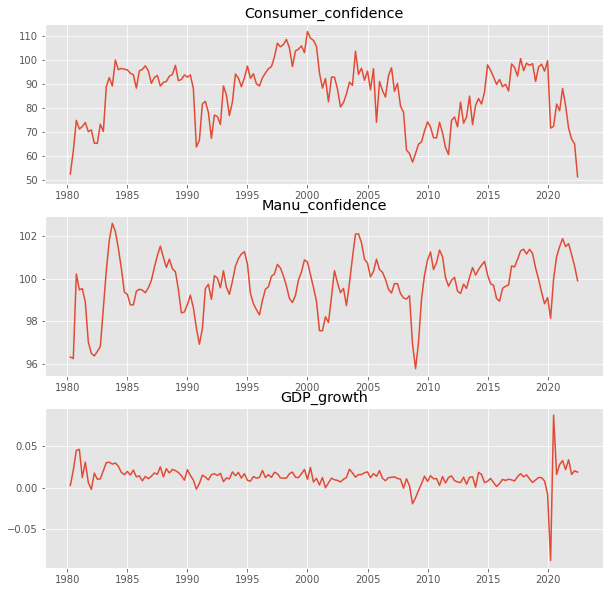

In [94]:
g = var_results.plot()

## <font face="gotham" color="purple"> Model Selection Criteria</font>

We have seen many times of $\text{AIC}$ and $\text{BIC}$ in printed linear regression results, the former tends to favor overfitting models and the latter underfitting models. 

In $\text{ARIMA}$ formulation, it's reasonable to choose a overparameterized model if it has sound theoretical foundation, however in $\text{VAR}$ formulation, we should select parsimonious model whenever possible, since it's intensively parameterized, that means we should use $\text{BIC}$ if no obvious reasons to deviate.

Hannan-Quinn Information Criterion ($\text{HQIC}$), Final Prediction Error ($\text{FPE}$) and Det(Omega_mle) are also provided, but not really providing extra values in most of cases.

## <font face="gotham" color="purple"> Strategy of Choosing Variables </font>

Construct a core VAR, then rotate with extra variable one by one, to avoid estimating too many coefficients at once.

## <font face="gotham" color="purple"> Forecasting </font>

Then:
$$
\begin{aligned}
& \mathbf{Y}_{\mathrm{t}-1}=\left(\mathbf{y}_{\mathrm{t}-1}, \mathbf{y}_{\mathrm{t}-2}, \ldots, \mathbf{y}_{\mathrm{t}-\mathrm{T}}\right) \\
& E\left[\mathbf{y}_{\mathrm{t}} \mid \mathbf{Y}_{\mathrm{t}-1}\right]=\widehat{\mathbf{G}}_0+\widehat{\mathbf{G}}_1 \mathbf{y}_{\mathrm{t}-1}+\widehat{\mathbf{G}}_2 \mathbf{y}_{\mathrm{t}-2}+\ldots+\widehat{\mathbf{G}}_{\mathrm{p}} \mathbf{y}_{\mathrm{t}-\mathrm{p}} \\
&
\end{aligned}
$$

This is dynamic forecast, iterating one period forward:
$$
E\left[\mathbf{y}_{t+1} \mid \mathbf{Y}_{t-1}\right]=\widehat{\mathbf{G}}_0+\widehat{\mathbf{G}}_1 \mathbf{E}\left[\mathbf{y}_t \mid \mathbf{Y}_{t-1}\right]+\widehat{\mathbf{G}}_2 \mathbf{y}_{t-1}+\ldots+\widehat{\mathbf{G}}_{\mathrm{p}} \mathbf{y}_{t-p+1}
$$
Iterating $j$ periods forward:
$$
E\left[\mathbf{y}_{\mathrm{t}+\mathrm{j}} \mid \mathbf{Y}_{\mathrm{t}-1}\right]=\widehat{\mathbf{G}}_0+\widehat{\mathbf{G}}_1 \mathrm{E}\left[\mathbf{y}_{\mathrm{t}+\mathrm{j}-1} \mid \mathbf{Y}_{\mathrm{t}-1}\right]+\widehat{\mathbf{G}}_2 \mathrm{E}\left[\mathbf{y}_{\mathrm{t}+\mathrm{j}-2} \mid \mathbf{Y}_{\mathrm{t}-1}\right]+\ldots+\widehat{\mathbf{G}}_{\mathrm{p}} \mathbf{y}_{\mathrm{t}-\mathrm{p}+\mathrm{j}}
$$

In [102]:
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Jan, 2023
Time:                     22:51:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.69104
Nobs:                     168.000    HQIC:                  -5.92305
Log likelihood:          -183.296    FPE:                 0.00228500
AIC:                     -6.08153    Det(Omega_mle):      0.00202162
--------------------------------------------------------------------
Results for equation Consumer_confidence
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         40.107613        48.182105            0.832           0.405
L1.Consumer_confidence         0.651873         0.084401            7.724           0.000
L1.Manu_co

In [103]:
var_results.params

,Consumer_confidence,Manu_confidence,GDP_growth
const,40.107613,22.901955,-0.085538
L1.Consumer_confidence,0.651873,0.004033,-0.000230
L1.Manu_confidence,0.592597,1.146938,0.004034
L1.GDP_growth,91.018775,-2.889913,-0.035202
L2.Consumer_confidence,0.238156,-0.007378,0.000168
L2.Manu_confidence,-0.909024,-0.372150,-0.003006
L2.GDP_growth,-19.635580,-6.691737,0.147677


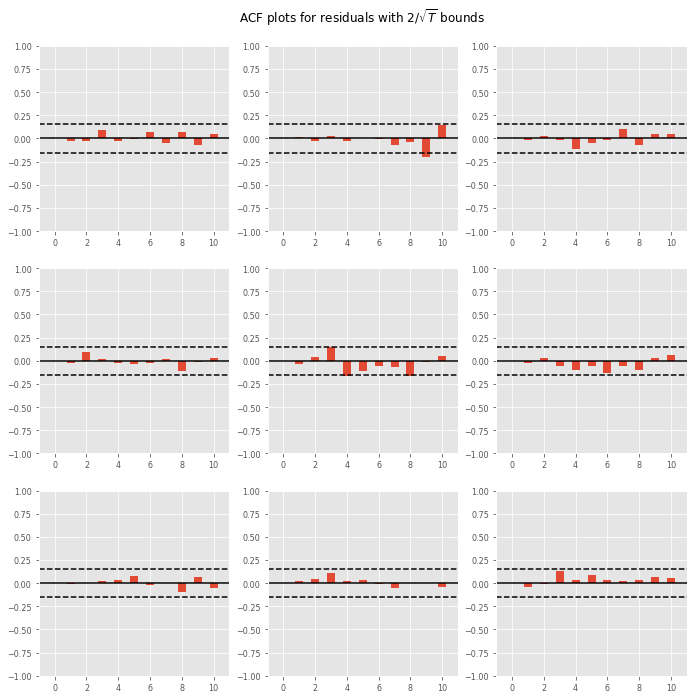

In [111]:
g_accor = var_results.plot_acorr(resid=True)

# <font face="gotham" color="purple"> Structural VAR</font>

Fed expected inflation rises higher, then Fed hikes rate to bring down the inflation. Can it be other way around? This is causality question to answer.

How about government expect household demand weakens, tax-cutting policies are on the table. 

Both monetary policy and fiscal policy are endogenously reacting to other variables. Key insight is you can't measure how effective the policies are when they are reacting to other variables.

To measure the effects of policy, we should let it be an exogenous shock to the economy and measure how other economic variables are responding to the policy shock, technically this is done by **impulse response function**.

Finding out the form of structural model is called **identification**.

$$
A  X_t=\beta_0+\beta_1 X_{t-1}+\mathrm{u}_t
$$

$$
\underbrace{\left[\begin{array}{cc}
1 & a_{12} \\
a_{21} & 1
\end{array}\right]}_{\mathrm{A}}\left[\begin{array}{c}
y_t \\
r_t
\end{array}\right]=\left[\begin{array}{l}
\beta_{10} \\
\beta_{20}
\end{array}\right]+\left[\begin{array}{ll}
\beta_{11} & \beta_{12} \\
\beta_{21} & \beta_{22}
\end{array}\right]\left[\begin{array}{l}
y_{t-1} \\
r_{t-1}
\end{array}\right]+\left[\begin{array}{l}
u_{y t} \\
u_{n t}
\end{array}\right]
$$

$A$ contains the contemporaneous relations among endogenous variables.

$$
{A}^{-1} {AX}_t=\overbrace{{A}^{-1} \beta_0}^{G_0}+\overbrace{{A}^{-1} \beta_1}^{G_1} {X}_{t-1}+{A}^{-1} u_t
$$

$$
{X}_t={G}_0+{G}_1 {X}_{t-1}+e_t, \quad {~A}^{-1} {A}={I}, \quad {e}_t={A}^{-1} u_t
$$

Forecast error $e$ is a linear combination of structural shocks $u$.

## <font face="gotham" color="purple">Identification</font>

SVAR can't be estimated directly since it is a theoretical framework, we have to start from estimation VAR model.

As an example
$$
\left[\begin{array}{l}
y_t \\
r_t
\end{array}\right]=\left[\begin{array}{l}
g_{10} \\
g_{20}
\end{array}\right]+\left[\begin{array}{ll}
g_{11} & g_{12} \\
g_{21} & g_{22}
\end{array}\right]\left[\begin{array}{l}
y_{t-1} \\
r_{t-1}
\end{array}\right]+\left[\begin{array}{l}
e_{3 t} \\
e_{n t}
\end{array}\right]\Rightarrow\begin{aligned}
& y_t=g_{10}+g_{11} y_{t-1}+g_{12} r_{t-1}+e_{y t} \\
& r_t=g_{20}+g_{21} y_{t-1}+g_{22} r_{t-1}+e_{r t}
\end{aligned}
$$
$9$ parameters to estimate, $6$ coefficients, $2$ variances (of residuals) and $1$ covariance (of residuals).

$$
\left[\begin{array}{cc}
1 & a_{12} \\
a_{21} & 1
\end{array}\right]\left[\begin{array}{c}
y_t \\
r_t
\end{array}\right]=\left[\begin{array}{l}
\beta_{10} \\
\beta_{20}
\end{array}\right]+\left[\begin{array}{ll}
\beta_{11} & \beta_{12} \\
\beta_{21} & \beta_{22}
\end{array}\right]\left[\begin{array}{c}
y_{t-1} \\
r_{t-1}
\end{array}\right]+\left[\begin{array}{l}
u_{y t} \\
u_{r t}
\end{array}\right]
$$

$10$ parameters to estimate, $8$ coefficients, $2$ variances (of residuals), covariance is zero due to independence of structural shocks. However reduced VAR can only get us max $9$ parameters, so here we need to impose some restrictions.

This is called identification of SVAR model, is to use priori knowledge to impose restrictions on matrix $A$.

$$
\underbrace{\left[\begin{array}{cc}
1 & 0 \\
a_{21} & 1
\end{array}\right]}_{{A}}\left[\begin{array}{l}
y_t \\
r_t
\end{array}\right]=\left[\begin{array}{l}
\beta_{10} \\
\beta_{20}
\end{array}\right]+\left[\begin{array}{ll}
\beta_{11} & \beta_{12} \\
\beta_{21} & \beta_{22}
\end{array}\right]\left[\begin{array}{l}
y_{t-1} \\
r_{t-1}
\end{array}\right]+\left[\begin{array}{l}
u_{y t} \\
u_{r t}
\end{array}\right]
$$

$$
\left[\begin{array}{l}
y_t \\
r_t
\end{array}\right]=\overbrace{\left[\begin{array}{cc}
1 & \mathbf{0} \\
-a_{21} & 1
\end{array}\right]}^{{A}^{-1}}\left[\begin{array}{l}
\beta_{10} \\
\beta_{20}
\end{array}\right]+\overbrace{\left[\begin{array}{cc}
1 & \mathbf{0} \\
-a_{21} & 1
\end{array}\right]}^{{A}^{-1}}\left[\begin{array}{ll}
\beta_{11} & \beta_{12} \\
\beta_{21} & \beta_{22}
\end{array}\right]\left[\begin{array}{l}
y_{t-1} \\
r_{t-1}
\end{array}\right]+\overbrace{\left[\begin{array}{cc}
1 & \mathbf{0} \\
-a_{21} & 1
\end{array}\right]}^{A^{-1}}\left[\begin{array}{l}
u_{y t} \\
u_{r t}
\end{array}\right]
$$

It becomes reduced-form VAR eventually.

$$
\left[\begin{array}{c}
y_t \\
r_t
\end{array}\right]=\left[\begin{array}{c}
\beta_{10} \\
-a_{21} \beta_{10}+\beta_{20}
\end{array}\right]+\left[\begin{array}{cc}
\beta_{11} & \beta_{12} \\
-a_{21} \beta_{11}+\beta_{12} & -a_{21} \beta_{12}+\beta_{22}
\end{array}\right]\left[\begin{array}{c}
y_{t-1} \\
r_{t-1}
\end{array}\right]+\left[\begin{array}{c}
u_{y t} \\
-a_{21} u_{y t}+u_{r t}
\end{array}\right]
$$

Every parameters estimated from reduced-VAR can help to recover the parameters in structural form, $9$ equations for $9$ parameters, for example
$$
\beta_{10} = g_{10}\\
-a_{21\beta_{10}+\beta_{20}}= g_{20}
$$

To summarize, the identification process is simply imposing restriction on matrix $A$ with priori knowledge or intuition.

## <font face="gotham" color="purple">Restrictions</font>

How many restrictions can we have? It's a simple math question.

Suppose you have $n$ variables, then matrix $A$ will be $n\times n$. However the diagonal of $A$ must be $1$'s, also there are $n$ variances of structural shocks unknown, that leaves us $n^2 + n - n = n^2$ unknowns.

There are $n+\frac{n^2-n}{2}=\frac{n^2+n}{2}$
known, which mean $n$ diagonal elements plus $\frac{n^2-n}{2}$ off-diagonal elements in covariance matrix of $E (e_t e_t^{T})=\Sigma_e$.

The number of restriction we can impose
$$
n^2 - \frac{n^2+n}{2}
$$

In [114]:
def getRestriction(n):
    return int(n**2 - (n**2 + n)/2)

In [121]:
getRestriction(7)

21

Christopher Sims suggests strategy called _Recursive Ordering_ for identification.

## <font face="gotham" color="purple">Impulse Response</font>

Wold representation to evaluate IRF

${X}_t=\mu+\sum_{i=0}^{\infty} \mathrm{C}_i {U}_{t-i}$

## <font face="gotham" color="purple">Variance Decomposition</font>

Forecast error decomposition can tell use how much movement is due to the shock of interest or other shocks.